# Random walk

In [1]:
import sys
import numpy as np
import corner
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import logging

from goldmine.simulators.random_walk_checkpointed import CheckpointedRandomWalk
from goldmine.inference.scandal_checkpointed import CheckpointedSCANDALInference

In [2]:
logging.basicConfig(format='%(asctime)s  %(message)s', datefmt='%H:%M')
logging.getLogger().setLevel(logging.INFO)

In [3]:
def ccolor(val, vmin, vmax, cmap='viridis'):
    cmap = matplotlib.cm.get_cmap(cmap)
    return cmap((val - vmin) / (vmax - vmin)).reshape(-1,)

## Setup

In [4]:
checkpoints = np.linspace(0.,1.,11)
xmin, xmax = -30, 50

## Test data

In [5]:
n_sim = 1000
n_plot = 100

theta_test = 110.

In [6]:
sim = CheckpointedRandomWalk()
x_test, t_xz_test, z_checkpoints_test, t_xz_checkpoints_test, z_test = sim.rvs_score([theta_test], [theta_test], n_sim, return_histories=True)


/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


## Load and evaluate model

In [7]:
inf = CheckpointedSCANDALInference(
    filename = "../../data/models/randomwalk/scandal_checkpoint/model"
)

15:46  Loaded checkpointed SCANDAL from file:
15:46    Filename:        ../../data/models/randomwalk/scandal_checkpoint/model
15:46    Checkpoint score estimator:
15:46      Hidden layers: (20, 20)
15:46      Activation:    <built-in method relu of type object at 0xb145ba870>
15:46      Parameters:    1
15:46      Latents:       1
15:46    Global flow:
15:46      Parameters:    1
15:46      Observables:   1
15:46      Components:    1
15:46      MADEs:         5
15:46      Hidden layers: (100,)
15:46      Activation:    tanh
15:46      Batch norm:    False


In [8]:
t_x_test = inf.predict_score(
    theta=theta_test * np.ones_like(t_xz_test),
    x=x_test
)
t_xv_checkpoints_test = inf.predict_checkpoint_scores(
    theta=theta_test * np.ones_like(t_xz_test),
    z_checkpoints=z_checkpoints_test
)

## Plot scores

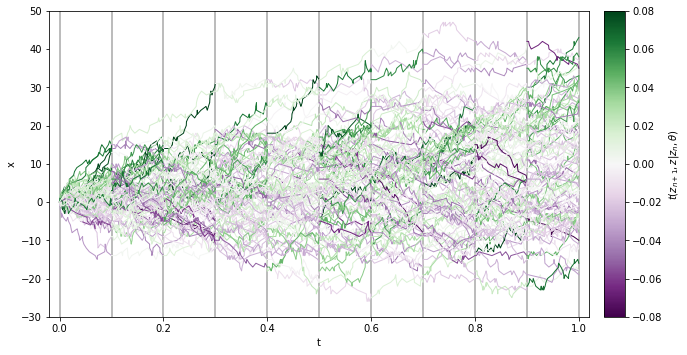

In [9]:
vmax = 0.08

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

# Checkpoints
for t_checkpoint in checkpoints:
    plt.plot(
        [t_checkpoint, t_checkpoint], [xmin, xmax],
        ls='-',
        c='0.65',
        lw=1.5
    )
    
# Joint scores for theta0 trajectories
for z, z_cp, t_xz in zip(z_test[:n_plot], z_checkpoints_test[:n_plot], t_xz_checkpoints_test[:n_plot]):
    for i in range(len(checkpoints) - 1):
        t = np.array(z)[:,0]
        x = np.array(z)[:,1]
        
        tmin, tmax = checkpoints[i], checkpoints[i+1]
        t_ = t[(t >= tmin) & (t < tmax)]
        x_ = x[(t >= tmin) & (t < tmax)]
        
        t_ = np.hstack([[checkpoints[i]], t_, [checkpoints[i+1]]])
        x_ = np.hstack([z_cp[i], x_, z_cp[i+1]])
        
        plt.plot(
            t_, x_,
            c=ccolor(t_xz[i+1], -vmax, vmax, 'PRGn'),
            ls='-', lw=1., alpha=1.
        )
    
plt.xlim(-0.02,1.02)
plt.ylim(xmin, xmax)

plt.xlabel('t')
plt.ylabel('x')

# Color bar
ax1 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
cb = matplotlib.colorbar.ColorbarBase(
    ax1, cmap=matplotlib.cm.get_cmap("PRGn"),
    norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax),
    orientation='vertical'
)
cb.set_label(r'$t(z_{n+1}, z | z_n, \theta)$')
    
plt.savefig('random_walk_joint_score.pdf')
plt.show()

## Plot estimated checkpoint scores

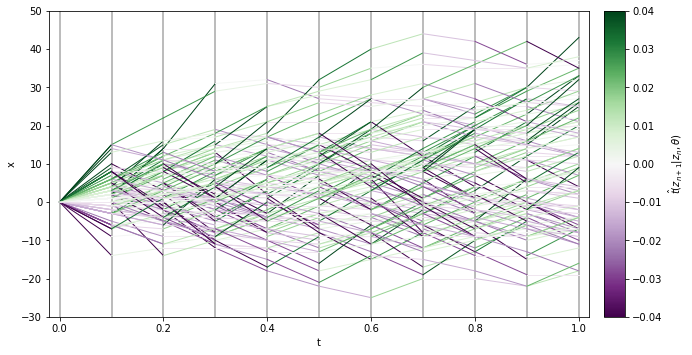

In [10]:
vmax = 0.04

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

# Checkpoints
for t_checkpoint in checkpoints:
    plt.plot(
        [t_checkpoint, t_checkpoint], [xmin, xmax],
        ls='-',
        c='0.65',
        lw=1.5
    )
    
# Joint scores for theta0 trajectories
for z, t_xz in zip(z_checkpoints_test[:n_plot], t_xv_checkpoints_test[:n_plot]):
    for i in range(len(checkpoints) - 1):
        plt.plot(
            [checkpoints[i], checkpoints[i+1]], [z[i,0], z[i+1,0]],
            c=ccolor(t_xz[i], -vmax, vmax, 'PRGn'),
            ls='-', lw=1., alpha=1.
        )
    
plt.xlim(-0.02,1.02)
plt.ylim(xmin, xmax)

plt.xlabel('t')
plt.ylabel('x')

# Color bar
ax1 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
cb = matplotlib.colorbar.ColorbarBase(
    ax1, cmap=matplotlib.cm.get_cmap("PRGn"),
    norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax),
    orientation='vertical'
)
cb.set_label(r'$\hat{t}(z_{n+1}| z_n, \theta)$')
    
plt.savefig('random_walk_checkpoint_score.pdf')
plt.show()

## Plot estimated overall score

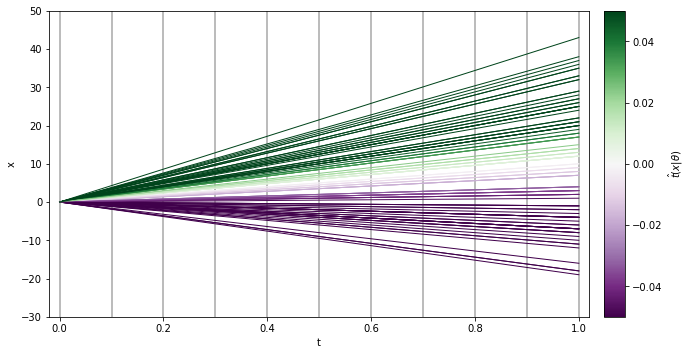

In [11]:
vmax = 0.05

fig = plt.figure(figsize=(10,5))
ax0 = fig.add_axes([0.1, 0.1, 0.75, 0.85])

# Checkpoints
for t_checkpoint in checkpoints:
    plt.plot(
        [t_checkpoint, t_checkpoint], [xmin, xmax],
        ls='-',
        c='0.65',
        lw=1.5
    )
    
# Joint scores for theta0 trajectories
for x, t_x in zip(x_test[:n_plot], t_x_test[:n_plot]):
    plt.plot(
        [0., 1.], [0.,x[0]],
        c=ccolor(t_x, -vmax, vmax, 'PRGn'),
        ls='-', lw=1., alpha=1.
    )
    
plt.xlim(-0.02,1.02)
plt.ylim(xmin, xmax)

plt.xlabel('t')
plt.ylabel('x')

# Color bar
ax1 = fig.add_axes([0.87, 0.1, 0.03, 0.85])
cb = matplotlib.colorbar.ColorbarBase(
    ax1, cmap=matplotlib.cm.get_cmap("PRGn"),
    norm=matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax),
    orientation='vertical'
)
cb.set_label(r'$\hat{t}(x|\theta)$')
    
plt.savefig('random_walk_score.pdf')
plt.show()

## Checkpoint-to-checkpoint score

In [12]:
in_micro = z_checkpoints_test[:, :-1, 0].flatten()
out_micro = z_checkpoints_test[:, 1:, 0].flatten()
diff_micro = out_micro - in_micro

t_xz_micro = t_xz_checkpoints_test[:, 1:, 0].flatten()
t_x_micro = t_xv_checkpoints_test[:, :, 0].flatten()

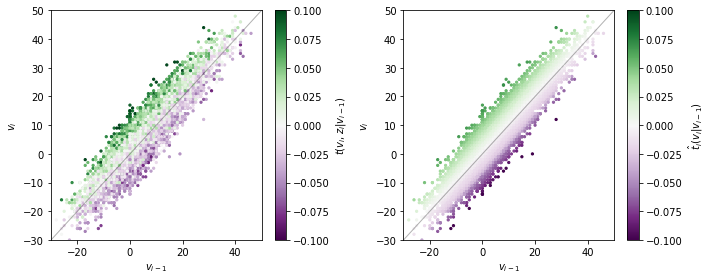

In [13]:
vmax = 0.1
fig = plt.figure(figsize=(10.,4.))


ax = plt.subplot(1,2,1)

sc = plt.scatter(in_micro, out_micro, c=t_xz_micro, cmap='PRGn', vmin=-vmax, vmax=vmax, s=5.)
plt.plot([xmin, xmax], [xmin, xmax], ls='-', lw=1., c='black', alpha=0.3)
cb = plt.colorbar(sc)

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel(r'$v_{i-1}$')
plt.ylabel(r'$v_{i}$')
cb.set_label(r'$t(v_i, z_i | v_{i-1})$')


ax = plt.subplot(1,2,2)

sc = plt.scatter(in_micro, out_micro, c=t_x_micro, cmap='PRGn', vmin=-vmax, vmax=vmax, s=5.)
plt.plot([xmin, xmax], [xmin, xmax], ls='-', lw=1., c='black', alpha=0.3)
cb = plt.colorbar(sc)

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel(r'$v_{i-1}$')
plt.ylabel(r'$v_{i}$')
cb.set_label(r'$\hat{t}_i(v_i | v_{i-1})$')


plt.tight_layout()
plt.savefig('random_walk_micro_score.pdf')


In [14]:
diff_boundaries = np.linspace(-15.5,15.5,32)
t_xz_micro_means = []

for left, right in zip(diff_boundaries[:-1], diff_boundaries[1:]):
    cut = np.logical_and((diff_micro >= left), (diff_micro < right))
    t_xz_micro_means.append(np.mean(t_xz_micro[cut]))
                         
t_xz_micro_means = np.asarray(t_xz_micro_means)
                         
diff_boundaries = np.repeat(diff_boundaries, 2)[1:-1]
t_xz_micro_means = np.repeat(t_xz_micro_means, 2)
                         

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


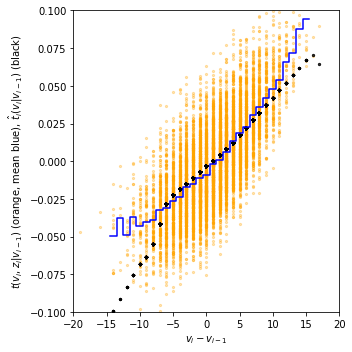

In [15]:
skip=1
vmax=0.1

fig = plt.figure(figsize=(5,5))

plt.scatter(diff_micro[::skip], t_xz_micro[::skip], c='orange', s=5., alpha=0.3)
plt.scatter(diff_micro[::skip], t_x_micro[::skip], c='black', s=5., alpha=0.4)
plt.plot(diff_boundaries, t_xz_micro_means, c='blue', lw=1.5, alpha=1.)

plt.xlabel(r'$v_i - v_{i-1}$')
plt.ylabel(r'$t(v_i, z_i | v_{i-1})$ (orange, mean blue), $\hat{t}_i(v_i | v_{i-1})$ (black)')

plt.xlim(-20., 20.)
plt.ylim(-vmax, vmax)

plt.tight_layout()
plt.savefig('random_walk_micro_score_vs_diff.pdf')


## Global model

In [16]:
x_macro = x_test.flatten()

t_xz_macro = t_xz_test
t_xv_macro = np.sum(t_xv_checkpoints_test, axis=1).flatten()
t_x_macro = t_x_test.flatten()

In [17]:
t_xv_macro

array([ 5.13769127e-02,  2.15007402e-02, -4.80721220e-02, -1.29106790e-01,
       -9.29045081e-02, -8.66142809e-02, -5.81226051e-02,  9.58326161e-02,
       -5.86885773e-02,  5.20907342e-02,  1.08944148e-01, -8.64375681e-02,
       -5.08406162e-02, -1.80669725e-02,  7.44351149e-02,  9.01126955e-03,
        5.74565232e-02, -6.29864186e-02, -4.47527431e-02, -5.20600341e-02,
        4.39962745e-02, -6.16669357e-02, -3.90713513e-02,  3.93047929e-02,
        1.53751403e-01, -7.12864101e-02, -8.01292956e-02, -6.59172833e-02,
       -1.20380580e-01,  1.92157626e-02,  3.75774205e-02, -1.26659852e-02,
        1.32699519e-01,  2.51886621e-03,  2.43958607e-02, -9.42085087e-02,
       -4.94834222e-03,  7.27057457e-02, -1.70061290e-02,  4.07539383e-02,
       -7.96540678e-02, -6.11033142e-02, -5.54741919e-02,  7.38905966e-02,
        1.13631636e-01,  5.90150245e-04,  1.46113643e-02,  3.99256088e-02,
       -7.94892013e-02,  1.72865707e-02, -3.80614661e-02, -1.48106948e-01,
       -1.26692176e-01, -

In [18]:
x_boundaries = np.linspace(xmin,xmax,int((xmax - xmin) / 2. + 1.))
t_xz_macro_means = []
t_xv_macro_means = []

for left, right in zip(x_boundaries[:-1], x_boundaries[1:]):
    cut = np.logical_and((x_macro >= left), (x_macro < right))
    t_xz_macro_means.append(np.mean(t_xz_macro[cut]))
    t_xv_macro_means.append(np.mean(t_xv_macro[cut]))
                         
t_xz_macro_means = np.asarray(t_xz_macro_means)
t_xv_macro_means = np.asarray(t_xv_macro_means)
                         
x_boundaries = np.repeat(x_boundaries, 2)[1:-1]
t_xz_macro_means = np.repeat(t_xz_macro_means, 2)
t_xv_macro_means = np.repeat(t_xv_macro_means, 2)
                         

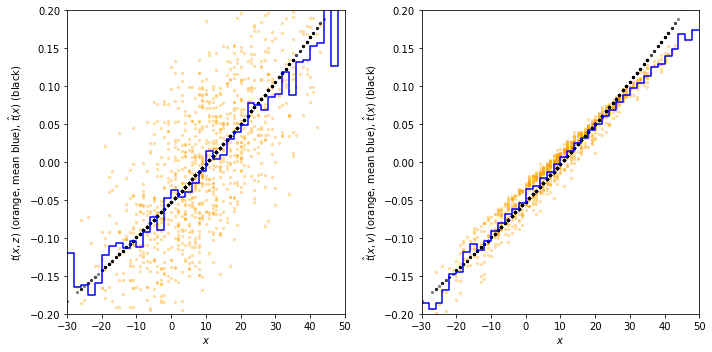

In [19]:
fig = plt.figure(figsize=(10,5))


ax = plt.subplot(1,2,1)

plt.scatter(x_macro, t_xz_macro, c='orange', s=5., alpha=0.3)
plt.scatter(x_macro, t_x_macro, c='black', s=5., alpha=0.4)
plt.plot(x_boundaries, t_xz_macro_means, c='blue', lw=1.5, alpha=1.)

plt.xlabel(r'$x$')
plt.ylabel(r'$t(x, z)$ (orange, mean blue), $\hat{t}(x)$ (black)')

plt.xlim(xmin, xmax)
plt.ylim(-0.2, 0.2)


ax = plt.subplot(1,2,2)

plt.scatter(x_macro, t_xv_macro, c='orange', s=5., alpha=0.3)
plt.scatter(x_macro, t_x_macro, c='black', s=5., alpha=0.4)
plt.plot(x_boundaries, t_xv_macro_means, c='blue', lw=1.5, alpha=1.)

plt.xlabel(r'$x$')
plt.ylabel(r'$\hat{t}(x, v)$ (orange, mean blue), $\hat{t}(x)$ (black)')

plt.xlim(xmin, xmax)
plt.ylim(-0.2, 0.2)



plt.tight_layout()
plt.savefig('random_walk_macro_score.pdf')
